# Electric Motor Temperature

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the [LEA department](https://ei.uni-paderborn.de/en/lea/) at Paderborn University. 
This data set is mildly anonymized.

## Content

All recordings are sampled at 2 Hz. 
The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id".
A measurement session can be between one and six hours long.

The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque.
Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.


## Inspiration

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

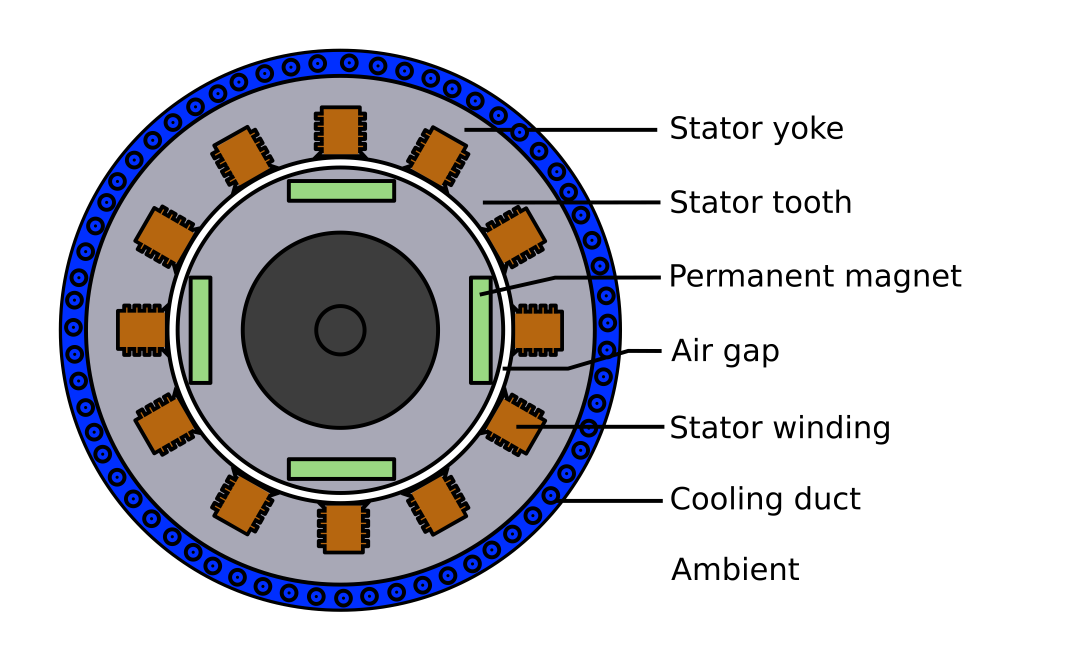

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.
A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

This is a [typical stator winding damage](http://www.aawva.com/resource/2016/3/25/typical-failures-in-three-phase-stator-windings):
![](https://images.squarespace-cdn.com/content/v1/56c20776f699bbc849dc0a69/1458920344064-XRVKU3O788XYJNS0TQ3A/ke17ZwdGBToddI8pDm48kH6fpDepVnHDbJBHVrcFH3VZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PICKwaTIMLhQJ9fACjqaf26fF01mQeTIdmmTPu11VCbBkKMshLAGzx4R3EDFOm1kBS/image-asset.jpeg?format=500w)

On the rotor part, irreversible demagnetization of the permanent magnets can be caused by overheating, which represents an even more severe instance of motor damage.

In the following, we analyze the data set and exhibit its peculiarities.

# Import libs and load data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
print(os.listdir("../input"))
plt.style.use('bmh')

In [ ]:
# read data
df = pd.read_csv('../input/measures_v2.csv')
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
df.shape

In [ ]:
df.describe()

# Measurement session lengths
The plots below show that all measurement sessions range from 20 minutes to around 6 hours.
The two short session ids "46" and "47" might be not very representative as temperatures inside electric motors need time to vary.

In [ ]:
p_counts = df.groupby('profile_id')['pm'].agg('count')
ax = p_counts.plot.barh(figsize=(10, 20), title='Sample size')
_ = ax.set_xticks(2*3600*np.arange(1, 8)) # 2Hz sample rate
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

In [ ]:
ax = p_counts.plot.hist(title='Sample size distribution', bins=50, figsize=(10, 5), grid=True)
_ = ax.set_xticks(2*3600*np.arange(1, 8)) # 2Hz sample rate
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

# Linear correlations

In [ ]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(14,14))
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We observe a very high positve linear correlation between *i_q* and *torque*.
Moreover, *u_d* is highly negative linearly correlated with *torque* and *i_q*.
Indeed, for the former insight we can refer to electric drive theory, where either higher torque is exclusively dependent on *i_q* in case of similar sized inductances in *d*- and *q*-axis, or increasing with higher *i_q* and slightly decreasing *i_d* elsewise (more common in practice).

# Distributions

In [ ]:
dfui = df.drop(['profile_id'], axis=1)  # dataframe under investigation

# prepare colors
color_list = plt.cm.tab10(np.linspace(0, 1, 10)[list(range(10))+[0, 1]])
coi = target_features + [c for c in dfui if c not in target_features]  # columns of interest
feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(coi)} if color_list is not None else {}

n_cols = 4
n_rows = np.ceil(dfui.shape[1] / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, col) in enumerate(zip(axes.flatten(), list(dfui.columns))):
    sns.distplot(dfui[col], color=feat_clrs[col], ax=ax)
    if i % n_cols == 0:
        ax.set_ylabel('Frequency')
plt.tight_layout()



We find
* distributions are not very gaussian,
* we often have multi-modal distributions,
* some features show a significant spike in their distribution. This is reasonable as these are the values that are held during no excitation (resting/cooldown phase)
* target temperatures are less spikey, indicating a slower progress or response to input features (read 'greater time constants').


# Time series gestalt

First we'll get an overview of the target temperature trends.

In [ ]:
grpd = {pid: df_ for pid, df_ in df.groupby('profile_id')}
coi = target_features
n_cols = 4
n_rows = np.ceil(len(grpd) / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    for c in coi:
        lines = ax.plot(df_[c].reset_index(drop=True), label=c, color=feat_clrs[c])
    ax.set_title(f'profile {p_id}')
    if i % n_cols == 0:
        ax.set_ylabel('Temp in °C')
    if i >= (len(grpd) - n_cols):
        ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)


Now we have a look at the input features

In [ ]:
coi = [c for c in dfui if c not in target_features + ['profile_id']]
max_values_per_col = dfui.abs().max(axis=0)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    for c in coi:
        lines = ax.plot(df_[c].reset_index(drop=True)/max_values_per_col[c], label=c, color=feat_clrs[c])
    ax.set_title(f'profile {p_id}')
    if i % n_cols == 0:
        ax.set_ylabel('Normalized feature')
    if i >= (len(grpd) - n_cols):
        ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

We find:
* While motor excitations (motor_speed, torque, coolant) are sometimes of high dynamic, sometimes of stepwise nature, target temperatures always exhibit low-pass behavior with exponential rise and falls,
* Coolant temperature suffers from measurement artefacts expressed by sharp drops in temperature, which recover as fast,
* PM (Permanent Magnet -> Rotor) temperature expresses the slowest time constant and follows stator temperatures
* Motor_speed and torque (the excitation features) follow sometimes step-wise cycles, sometimes random walks
* Some profiles denote resting phases, where all input features stay constant most of the time

## Operation points

The operation point of a motor is often explained by its location in the motor_speed-torque-plane.

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, sharex=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    ax.plot(df_.motor_speed, df_.torque)
    ax.set_title(f'profile {p_id}')
    if i % n_cols == 0:
        ax.set_ylabel('Torque in Nm')
    if i >= len(grpd)-n_cols:
        ax.set_xlabel('Motor speed in rpm')

We see that some driving cycles only capture little of the valid operation region, while other profiles do comprehensive random walks over the full operative range.

Note that motors are power rated, and since power is defined as $P = motorspeed \cdot torque$, there are elliptical borders that can't be exceeded.

By the way, profile no. 11 denotes the repeated [FTP-75](https://dieselnet.com/standards/cycles/ftp75.php).

Let's have a look at a heat map that shows which operation points where visited how often (brighter areas are visited more often).

In [ ]:
# heat map
N_BINS = 100
dfui = df.assign(binned_torque=pd.cut(df.torque.values.ravel(), bins=N_BINS, include_lowest=True),
                 binned_speed=pd.cut(df.motor_speed.values.ravel(), bins=N_BINS, include_lowest=True))

ts_map = dfui.loc[:, ['binned_torque', 'binned_speed', 'torque']]\
            .groupby(['binned_torque', 'binned_speed']).count().fillna(0).reset_index()\
            .rename(columns={'torque': 'count'})\
            .pivot(index='binned_torque', columns='binned_speed', values='count')\
            .sort_values('binned_torque', ascending=False)
plt.figure(figsize=(6, 4))
ax = sns.heatmap(ts_map, robust=True, square=True, yticklabels=49, xticklabels=49, cbar=False)
_ = ax.set_ylabel('Torque p.u.')
_ = ax.set_xlabel('Motor speed p.u.')
_ = ax.set_xticklabels([0, 0.5, 1], rotation=0)
_ = ax.set_yticklabels([1, 0, -1])
plt.tight_layout()

## Dimensionality reduced visualization
We further depict all recording sessions in terms of their principal component axes, shifting the color from blue to red as the permanent magnet temperature rises.

### All profiles separated
Showing the two most significant principal components.

In [ ]:
_df = df.loc[~df.profile_id.isin([46, 47])].reset_index(drop=True)
# normalize
_df = _df / _df.abs().max(axis=0)
transformed = PCA().fit_transform(_df.drop(['profile_id']+target_features, axis=1))
N = len(_df.profile_id.unique())
cols = min(10, N)
rows = np.ceil(N/10)
plt.figure(figsize=(2*cols, 2*rows))
for i, (sess_id, sess_df) in enumerate(_df.groupby(['profile_id'])):
    plt.subplot(rows, cols, i+1)
    _trans = transformed[sess_df.index, :]
    plt.scatter(_trans[:, 0], _trans[:, 1], c=_df.loc[sess_df.index, 'pm'].values, cmap=plt.get_cmap('coolwarm'), marker='.', vmin=_df['pm'].min(), vmax=_df['pm'].max())
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                            labelbottom=False, right=False, left=False,
                            labelleft=False)
    plt.annotate(str(sess_id), (4.8, -4.8))
plt.tight_layout()

It becomes obvious that lower profile IDs are of simpler driving cycles, not moving much in feature space.
Higher profile IDs are driving cycles of high dynamics - excitation happened through random walks in the motor_speed-torque-plane.

### All profiles condensed 
Showing increasing principal component significance from right to left.

In [ ]:
fig = plt.figure(figsize=(17, 3))
cols = 4
for i in range(cols):
    plt.subplot(1, cols, i+1)
    plt.scatter(transformed[:, i], transformed[:, i+1], c=_df.pm.values, cmap=plt.get_cmap('coolwarm'), marker='.', vmin=_df['pm'].min(), vmax=_df['pm'].max())
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.show()

We find:
* No gaussian distributions are recognizable,
* nor is the target temperature distinguishable in the spatial dimension,
* good features need to be found, different from the raw sensor data.

# Baseline Predictions with Ordinary Least Squares and Random Forest Regression
In the following we try to predict the permanent magnet temperature *pm*.

In [ ]:
def evaluate_baseline(data):
    scaler = StandardScaler()
    # please note that we standardize the full data here, yet this is not statistically sound procedure.
    # In order to get an unflawed generalization measure of any model evaluated on the data only the training set should be used for fitting the scaler.
    # Depending on the CV used this might mean to scale repeatedly with different subsets
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    trainset = scaled_data.loc[:, [c for c in data.columns if c not in ['profile_id']+target_features]]
    target = scaled_data.loc[:, 'pm']
    
    # Use k-fold CV to measure generalizability
    ols = LinearRegression(fit_intercept=False)
    print('Start fitting OLS...')
    scores = cross_val_score(ols, trainset, target, cv=5, scoring='neg_mean_squared_error')
    print(f'OLS MSE: {-scores.mean():.4f} (+/- {scores.std()*2:.3f})\n')  # mean and 95% confidence interval

    rf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
    print('Start fitting RF...')
    scores = cross_val_score(rf, trainset, target, cv=5, scoring='neg_mean_squared_error')
    print(f'RF MSE: {-scores.mean():.4f} (+/- {scores.std()*2:.3f})\n')  # mean and 95% confidence interval

## Fitting on raw data

In [ ]:
evaluate_baseline(df)

## Feature Engineering
We add some static features, that we can infer from the given raw signals and might help expose relevant patterns.

In [ ]:
extra_feats = {
     'i_s': lambda x: np.sqrt(x['i_d']**2 + x['i_q']**2),  # Current vector norm
     'u_s': lambda x: np.sqrt(x['u_d']**2 + x['u_q']**2),  # Voltage vector norm
     'S_el': lambda x: x['i_s']*x['u_s'],                  # Apparent power
     'P_el': lambda x: x['i_d'] * x['u_d'] + x['i_q'] *x['u_q'],  # Effective power
     'i_s_x_w': lambda x: x['i_s']*x['motor_speed'],
     'S_x_w': lambda x: x['S_el']*x['motor_speed'],
}
df = df.assign(**extra_feats)

Moreover, the trend in the raw signals is of very high information as has been mentioned in literature (see [ResearchGate Paper](https://www.researchgate.net/publication/331976678_Empirical_Evaluation_of_Exponentially_Weighted_Moving_Averages_for_Simple_Linear_Thermal_Modeling_of_Permanent_Magnet_Synchronous_Machines)).
We can compute the trend by calculating _exponentially weighted moving averages_ (EWMA). Note, that this is nothing more than low-pass filtering the signals.

In [ ]:
spans = [6360, 3360, 1320, 9480]  # these values correspond to cutoff-frequencies in terms of low pass filters, or half-life in terms of EWMAs, respectively
max_span = max(spans)
enriched_profiles = []
for p_id, p_df in df.groupby(['profile_id']):
    target_df = p_df.loc[:, target_features].reset_index(drop=True)
    # pop out features we do not want to calculate the EWMA from
    p_df = p_df.drop(target_features + ['profile_id'], axis=1).reset_index(drop=True)
    
    # prepad with first values repeated until max span in order to get unbiased EWMA during first observations
    prepadding = pd.DataFrame(np.zeros((max_span, len(p_df.columns))),
                              columns=p_df.columns)
    temperature_cols = [c for c in ['ambient', 'coolant'] if c in df]
    prepadding.loc[:, temperature_cols] = p_df.loc[0, temperature_cols].values

    # prepad
    prepadded_df = pd.concat([prepadding, p_df], axis=0, ignore_index=True)
    ewma = pd.concat([prepadded_df.ewm(span=s).mean().rename(columns=lambda c: f'{c}_ewma_{s}') for s in spans], axis=1).astype(np.float32)
    ewma = ewma.iloc[max_span:, :].reset_index(drop=True)  # remove prepadding
    assert len(p_df) == len(ewma) == len(target_df), f'{len(p_df)}, {len(ewma)}, and {len(target_df)} do not match'
    new_p_df = pd.concat([p_df, ewma, target_df], axis=1)
    new_p_df['profile_id'] = p_id
    enriched_profiles.append(new_p_df.dropna())
enriched_df = pd.concat(enriched_profiles, axis=0, ignore_index=True)  


p_ids = enriched_df.pop('profile_id')



## Fitting on engineered data

In [ ]:
enriched_df.head()

In [ ]:
evaluate_baseline(enriched_df)